In [1]:
import sys
sys.path.insert(0, "../../")

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'FAB',
 'FAB_vs_NF.ipynb',
 'ManyWell.png',
 'ManyWell_FAB.png',
 'ManyWell_NF.png',
 'NF',
 'Workshop_run_FAB.ipynb',
 'Workshop_run_NF.ipynb']

In [3]:
import torch
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from datetime import datetime

In [4]:
import pathlib
def load_model(tester, checkpoints_path, epoch, load_AIS=True):
    path = pathlib.Path(checkpoints_path)
    tester.learnt_sampling_dist.load_model(path, epoch)
    if load_AIS:
        tester.AIS_train.transition_operator_class.load_model(path, epoch)

# Target Problem

In [5]:
dim = 16
non_default_flow_width = None

In [6]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)
def plotter(*args, **kwargs):
    plot_samples_vs_contours_many_well(*args, **kwargs)

if non_default_flow_width is None:
    scaling_factor_flow = 2.0
else:
    scaling_factor_flow = non_default_flow_width

# FAB

In [7]:
problem = "ManyWell"
seed = 0
problem_kwargs = {}
save = True
epochs = int(1e5)
batch_size = int(1e3)
n_samples_expectation = batch_size*10
KPI_batch_size = batch_size*10
n_flow_steps = 20
n_plots = 5
n_distributions = 2 + 2
experiment_name = "workshop_NF"
flow_type = "RealNVP" 
HMC_tune_options = [ "No-U", "p_accept", "No-U-unscaled" ]
HMC_transition_args = {"step_tuning_method": HMC_tune_options[1]}
train_AIS_kwargs = {"lr": 2e-4, "optimizer": "AdamW"}
learnt_sampler_kwargs = {"nodes_per_x": 10}

In [8]:
learnt_sampler_FAB = FlowModel(x_dim=dim, scaling_factor=scaling_factor_flow, flow_type=flow_type,
                               n_flow_steps=n_flow_steps, **learnt_sampler_kwargs)
FAB = AIS_trainer(target, learnt_sampler_FAB, n_distributions=n_distributions
                     , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC",
                     **train_AIS_kwargs)

setting device as cpu


In [9]:
os.listdir("FAB")

['HMC_model', 'model']

In [10]:
load_model(FAB,"FAB", epoch=None, load_AIS=True)

loaded flow model
loaded HMC model


In [11]:
test_samples = target.test_set("cpu")
log_probs_test = FAB.learnt_sampling_dist.log_prob(test_samples)
mean_log_q_x_test_samples = torch.mean(log_probs_test).item()
mean_log_q_x_test_samples

-14.553335928472034

In [12]:
#plot_samples_vs_contours_many_well(FAB)

# NF

In [13]:
problem = "ManyWell"
dim = 16
seed = 0
problem_kwargs = {}
save = True
epochs = int(1e5)
batch_size = int(1e3)
n_samples_expectation = batch_size*10
KPI_batch_size = batch_size*10
n_flow_steps = 20
n_plots = 5
n_distributions = 2 + 0
experiment_name = "workshop_NF"
flow_type = "RealNVP" 
HMC_tune_options = [ "No-U", "p_accept", "No-U-unscaled" ]
HMC_transition_args = {"step_tuning_method": HMC_tune_options[1]}
train_AIS_kwargs = {"lr": 2e-4, "optimizer": "AdamW", 
                    "loss_type":  "kl_q"}
learnt_sampler_kwargs = {"nodes_per_x": 10}

In [14]:
learnt_sampler_NF = FlowModel(x_dim=dim, scaling_factor=scaling_factor_flow, flow_type=flow_type,
                               n_flow_steps=n_flow_steps, **learnt_sampler_kwargs)
NF_model = AIS_trainer(target, learnt_sampler_NF, n_distributions=n_distributions
                     , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC",
                     **train_AIS_kwargs)

running without any intermediate distributions
setting device as cpu


In [15]:
load_model(NF_model,"NF", epoch=None, load_AIS=False)

loaded flow model


In [16]:
test_samples = target.test_set("cpu")
log_probs_test = NF_model.learnt_sampling_dist.log_prob(test_samples)
mean_log_q_x_test_samples = torch.mean(log_probs_test).item()
mean_log_q_x_test_samples

-86.6964087562947

In [17]:
#plot_samples_vs_contours_many_well(NF_model)

# Plotting

In [18]:
import numpy as np

In [23]:
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
import matplotlib as mpl
import itertools

mpl.rcParams['figure.dpi'] = 300
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
rc('axes', titlesize=10, labelsize = 8)     # fontsize of the axes title and labels
rc('legend',fontsize=8)
rc('xtick', labelsize=7) 
rc('ytick', labelsize=7)
rc("lines", linewidth=0.8)
rc("lines", markersize=0.5)

In [24]:
def plot_marginals(learnt_dist_manager, supfig, y_axis_label=True, n_samples=1000, title=None, samples_q=None,
                   clamp_samples=10, alpha=0.2, dim=None, n_points_contour=200, marker='o', log=True
                   , n_contour_lines=10, clip_min=-10):
    # currenntly assuming this is used for Many well problem
    if log is True:
        map_log_or_exp = lambda x: torch.clamp_min(x, clip_min)
    else:
        map_log_or_exp = lambda x: torch.exp(x)
    if dim is None:
        dim = learnt_dist_manager.target_dist.dim
    if samples_q is None:
        samples_q = learnt_dist_manager.learnt_sampling_dist.sample((n_samples,))
    if isinstance(clamp_samples, int) or isinstance(clamp_samples, float) :
        samples_q = torch.clamp(samples_q, -clamp_samples, clamp_samples).cpu().detach().numpy()
    else:
        for i, clamp_dim in enumerate(clamp_samples):  # list of min max per dimension
            samples_q[:, i] = torch.clamp(samples_q[:, i], clamp_dim[0], clamp_dim[1])
        samples_q = samples_q.cpu().detach().numpy()
    if dim == 2:
        if learnt_dist_manager is not None:
            if isinstance(clamp_samples, int):
                x_points_dim1 = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
                x_points_dim2 = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
            else:
                x_points_dim1 = torch.linspace(clamp_samples[0][0], clamp_samples[0][1], n_points_contour)
                x_points_dim2 = torch.linspace(clamp_samples[1][0], clamp_samples[1][1], n_points_contour)
            x_points = torch.tensor(list(itertools.product(x_points_dim1, x_points_dim2)))
            p_x = learnt_dist_manager.target_dist.log_prob(x_points.to(learnt_dist_manager.device))
            p_x = map_log_or_exp(p_x)
            p_x = p_x.cpu().detach().numpy()
            p_x = p_x.reshape((n_points_contour, n_points_contour))
            x_points_dim1 = x_points[:, 0].reshape((n_points_contour, n_points_contour)).numpy()
            x_points_dim2 = x_points[:, 1].reshape((n_points_contour, n_points_contour)).numpy()
            plt.contour(x_points_dim1, x_points_dim2, p_x, levels= n_contour_lines)
            plt.xlabel(r"$x_1$")
            plt.ylabel(r"$x_2$")
        plt.plot(samples_q[:, 0], samples_q[:, 1], marker, alpha=alpha)
        if title != None:
            plt.suptitle(title)
    else:
        # we do following trick because dim are indpependant
        # first get varying log probs
        x_varying = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
        x_zeros = torch.zeros_like(x_varying)
        x_points_double_well_dim = torch.stack([x_varying, x_zeros]).T
        contours_double_well_dim = learnt_dist_manager.target_dist.log_prob_2D(x_points_double_well_dim)

        # next we get non_varying dim
        x_points_uni_modal = torch.stack([x_zeros, x_varying]).T
        contours_uni_modal_dim = learnt_dist_manager.target_dist.log_prob_2D(x_points_uni_modal)

        x_points = torch.tensor(list(itertools.product(x_varying, x_varying)))
        x_points_dim1 = x_points[:, 0].reshape((n_points_contour, n_points_contour)).numpy()
        x_points_dim2 = x_points[:, 1].reshape((n_points_contour, n_points_contour)).numpy()
        well_contours_z = {}
        well_contours_z["well-well"] = map_log_or_exp(contours_double_well_dim[:, None] + contours_double_well_dim[None, :])
        well_contours_z["no-well"] = map_log_or_exp(contours_uni_modal_dim[:, None] + contours_double_well_dim[None, :])
        well_contours_z["well-no"] = map_log_or_exp(contours_double_well_dim[:, None] + contours_uni_modal_dim[None, :])
        well_contours_z["no-no"] = map_log_or_exp(contours_uni_modal_dim[:, None] + contours_uni_modal_dim[None, :])

        axs = supfig.subplots(2, 2, sharex="row", sharey="row")
        #if title != None:
        #    supfig.suptitle(title)
        for i in range(2):
            for j in range(2):
                dim_1_name = ["well", "no"][i % 2]
                dim_2_name = ["well", "no"][j % 2]
                axs[i, j].plot(samples_q[:, j+2], samples_q[:, i],  marker, alpha=alpha)
                axs[i, j].set_xlim(-clamp_samples, clamp_samples)
                axs[i, j].set_ylim(-clamp_samples, clamp_samples)
                axs[i, j].contour(x_points_dim2, x_points_dim1, 
                                  well_contours_z[f"{dim_1_name}-{dim_2_name}"],
                            levels= n_contour_lines, 
                                  cmap=truncate_colormap(mpl.cm.viridis, minval = 0.05, n=n_contour_lines))
                if j == 0 and y_axis_label:
                    axs[i, j].set_ylabel(f"$x_{i +1}$")
                if i == 1:
                    axs[i, j].set_xlabel(f"$x_{j + 1 + 2}$")

    #plt.tight_layout()

In [25]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.flip(1 - np.geomspace(minval, maxval, n) + minval)))
    return new_cmap

In [26]:
plotting_batch_size = 1000
width = 5.5
height = 3.0

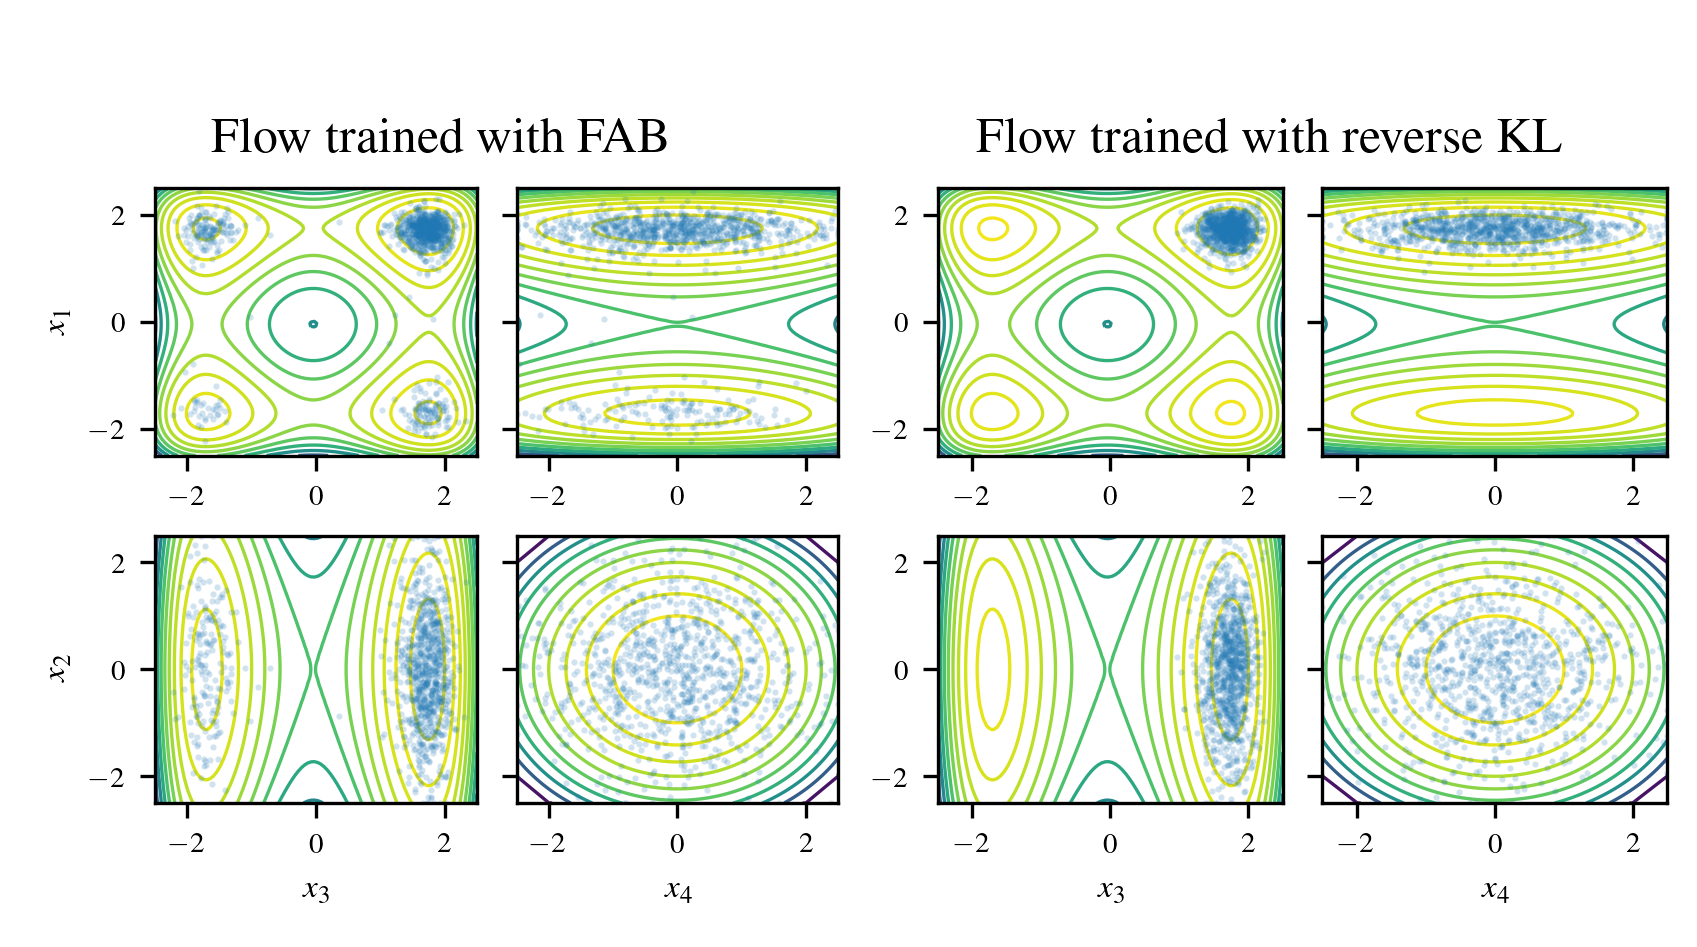

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(width, height))
subfigs = fig.subfigures(1, 2, wspace=0.01)
plot_marginals(FAB, subfigs[0], n_samples=plotting_batch_size,
               clamp_samples=2.5, alpha=0.2, dim=None, n_points_contour=100, marker="o",
               n_contour_lines=10, clip_min=-5, title="Flow trained with FAB")
subfigs[0].suptitle("Flow trained with FAB")
plot_marginals(NF_model, subfigs[1], n_samples=plotting_batch_size, y_axis_label=False,
               clamp_samples=2.5, alpha=0.2, dim=None, n_points_contour=100, marker="o",
               n_contour_lines=10, clip_min=-5, title=None)
subfigs[1].suptitle("Flow trained with reverse KL")
fig.suptitle(' ', fontsize='xx-large')
plt.savefig("ManyWell.png", bbox_inches='tight')

In [200]:
plot_marginals(FAB, n_samples=plotting_batch_size, title=None,
               clamp_samples=2.5, alpha=0.2, dim=None, n_points_contour=100, marker="o",
               n_contour_lines=10, clip_min=-5)
plt.savefig("ManyWell_FAB.png", bbox_inches='tight')

TypeError: plot_marginals() missing 1 required positional argument: 'supfig'

In [201]:
plot_marginals(NF_model, n_samples=plotting_batch_size, title=None,
               clamp_samples=2.5, alpha=0.5, dim=None, n_points_contour=100, marker="x",
               n_contour_lines=10, clip_min=-5)
plt.savefig("ManyWell_NF.png", bbox_inches='tight')

TypeError: plot_marginals() missing 1 required positional argument: 'supfig'